## Forecasting U.S. natural gas prices

## 2. Data

In [45]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [46]:
# Load your dataset
gas = pd.read_csv("data/MHHNGSP.csv")
gas['observation_date'] = pd.to_datetime(gas['observation_date'])
gas.set_index('observation_date', inplace=True)
gas = gas.asfreq('MS')  # monthly data
gas.rename(columns={'MHHNGSP': 'price'}, inplace=True)

Treat this series as monthly data, with observations corresponding to the start of each month

In [47]:
print(gas.head())
print(gas.tail())
print(f"Observations: {gas.notna().sum()}")

                  price
observation_date       
1997-01-01         3.45
1997-02-01         2.15
1997-03-01         1.89
1997-04-01         2.03
1997-05-01         2.25
                  price
observation_date       
2025-06-01         3.02
2025-07-01         3.20
2025-08-01         2.91
2025-09-01         2.97
2025-10-01         3.19
Observations: price    346
dtype: int64


In [48]:
len(gas)

346

In [49]:
# Check gaps
expected = pd.date_range(gas.index.min(), gas.index.max(), freq="MS")
missing = expected.difference(gas.index)
print(f"Missing months: {len(missing)}")

Missing months: 0


### Plot price 

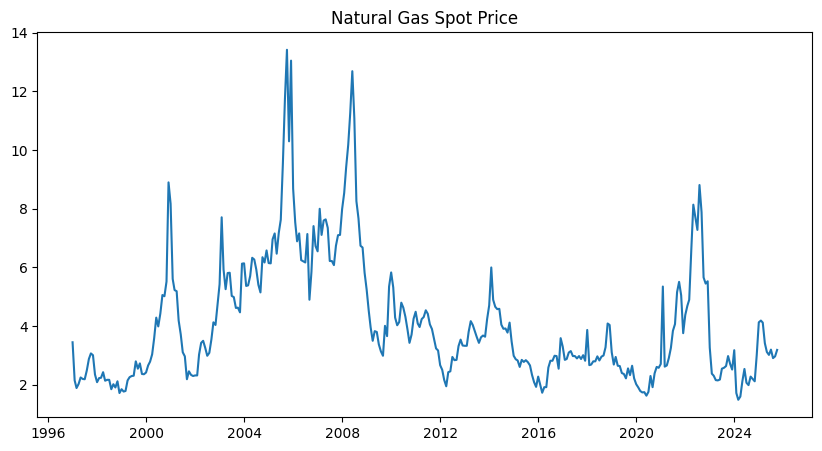

In [50]:
plt.figure(figsize=(10,5))
plt.plot(gas.index, gas['price'], label='Price')
plt.title("Natural Gas Spot Price")
plt.show()

### Logarithmic transformation of gas price

- Variable: Henry Hub natural gas spot price (USD/MMBtu), monthly, NSA
- Transforms: log(p_t) (variance stabilization)

In [51]:
gas['log_price'] = np.log(gas['price'])

### Plot log-level

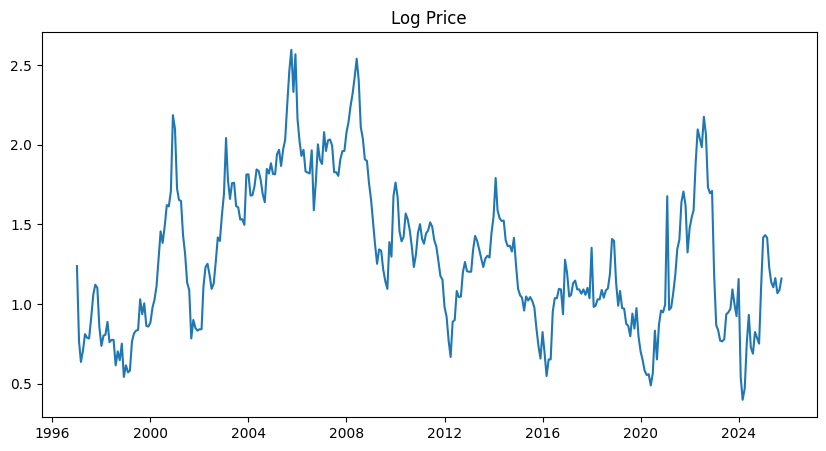

In [52]:
plt.figure(figsize=(10,5))
plt.plot(gas.index, gas['log_price'], label='Log Price')
plt.title("Log Price")
plt.show()

### ACF and PACF of Levels and Differences

(Detect trend, seasonality, cycles quantitatively)

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

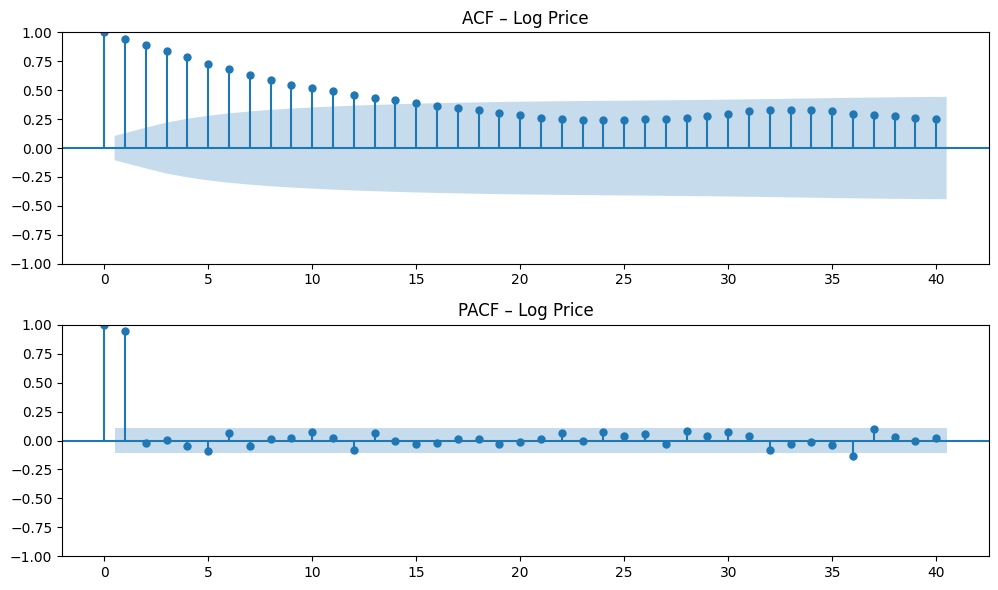

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
plot_acf(gas['log_price'].dropna(), lags=40, ax=ax[0])
# ACF to see seasonal spikes at lag 12, 24
ax[0].set_title("ACF – Log Price")
plot_pacf(gas['log_price'].dropna(), lags=40, ax=ax[1])
ax[1].set_title("PACF – Log Price")
plt.tight_layout()
plt.show()


### ACF/PACF of differenced log price

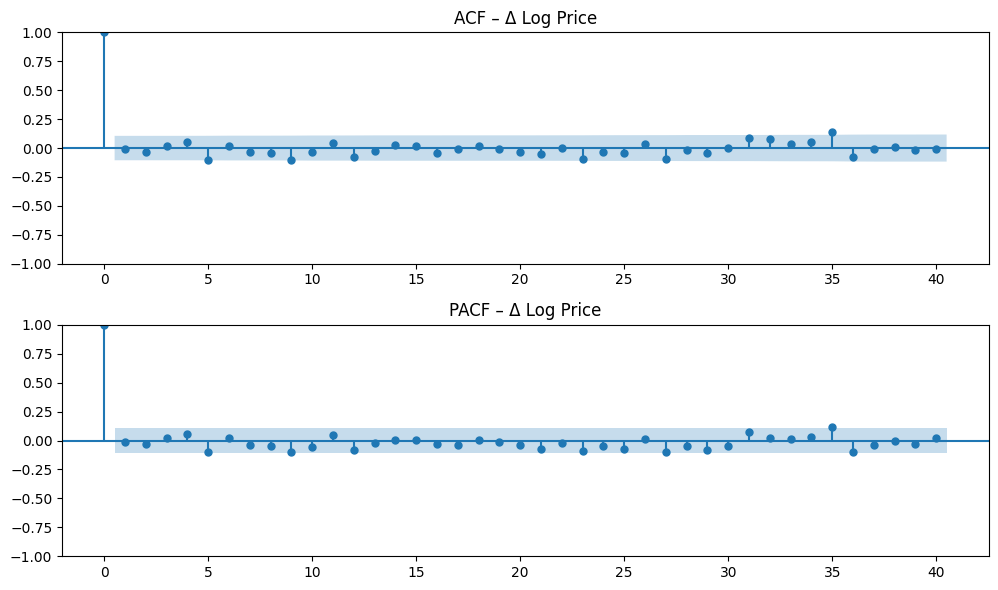

In [55]:
gas['dlog'] = gas['log_price'].diff()

fig, ax = plt.subplots(2, 1, figsize=(10,6))
plot_acf(gas['dlog'].dropna(), lags=40, ax=ax[0])
ax[0].set_title("ACF – Δ Log Price")
plot_pacf(gas['dlog'].dropna(), lags=40, ax=ax[1])
ax[1].set_title("PACF – Δ Log Price")
plt.tight_layout()
plt.show()

### Check stationarity with DF test on log_price and dlog

DF (Dickey–Fuller) test: H₀ = unit root (non-stationary). Low p-value → reject non-stationary → stationary.

In [56]:
from statsmodels.tsa.stattools import adfuller, kpss

def run_adf(x):
    res = adfuller(x.dropna(), autolag="AIC")
    return {"stat": res[0], "pvalue": res[1]}

log_x = gas['log_price']
dlog_x = gas['dlog']

print("Log/Diff series:")
print("  ADF :", run_adf(log_x))
print("  ADF :", run_adf(dlog_x))

Log/Diff series:
  ADF : {'stat': np.float64(-3.094343749296179), 'pvalue': np.float64(0.02697461797215903)}
  ADF : {'stat': np.float64(-18.922696691951774), 'pvalue': 0.0}


## 3. Methods and models

### Model selection and justification

In [57]:
from statsmodels.tsa.arima.model import ARIMA
from pandas_datareader import data as pdr

Train/test split with last 20% as holdout

In [58]:
# Ensure y is your monthly series (MS) with float dtype, as in your code
n = len(gas['log_price'].dropna())
h_test = max(1, int(np.floor(0.20 * n)))  # 20% holdout
y_train = gas['log_price'].iloc[:-h_test]
y_test  = gas['log_price'].iloc[-h_test:]

print(f"Train: {y_train.index[0].date()} → {y_train.index[-1].date()}  (n={len(y_train)})")
print(f"Test : {y_test.index[0].date()} → {y_test.index[-1].date()}    (n={len(y_test)})")

Train: 1997-01-01 → 2020-01-01  (n=277)
Test : 2020-02-01 → 2025-10-01    (n=69)


### AIC/BIC model selection for univariate ARIMA on log_price

In [59]:
y_train_series = y_train  # just to have a clear name

candidate_orders = [
    (1, 0, 0),
    (2, 0, 0),
    (1, 0, 1),
    (0, 0, 1)
]

results_uni = []

for order in candidate_orders:
    model = ARIMA(y_train_series, order=order)
    fit   = model.fit()
    results_uni.append({
        "order": order,
        "aic": fit.aic,
        "bic": fit.bic
    })

aic_uni_df = pd.DataFrame(results_uni).sort_values("aic")
print(aic_uni_df)

best_order_uni = aic_uni_df.iloc[0]["order"]
print("Chosen univariate ARIMA order (p,d,q):", best_order_uni)


       order         aic         bic
0  (1, 0, 0) -328.446992 -317.574940
1  (2, 0, 0) -326.754998 -312.258928
2  (1, 0, 1) -326.735584 -312.239514
3  (0, 0, 1)   84.216137   95.088190
Chosen univariate ARIMA order (p,d,q): (1, 0, 0)


Helper: expanding-window ARIMA forecaster
- We'll use this for the benchmark and AR(1)

In [77]:
def rolling_arima_forecast(y, order, train_size, trend='n'):
    """
    y: Series (e.g. log_price)
    order: (p,d,q)
    train_size: initial length of training sample
    trend: 'n' (no trend), 't' (linear trend), 'ct' (const + trend for d=0)
    """
    y = y.dropna()
    T = len(y)
    forecasts = []
    idx_fore = y.index[train_size:]

    for i in range(train_size, T):
        y_train = y.iloc[:i]
        model = ARIMA(y_train, order=order, trend=trend)
        fit = model.fit()
        f = fit.forecast(steps=1)[0]
        forecasts.append(f)

    forecasts = pd.Series(forecasts, index=idx_fore)
    actuals = y.iloc[train_size:]
    return forecasts, actuals


1.1 Benchmark model - Random walk without drift ARIMA(0,1,0)

In [78]:
y_full = gas['log_price']
train_size = len(y_train)

f_rw_nodrift, a_rw_nodrift = rolling_arima_forecast(
    y_full,
    order=(0, 1, 0),
    train_size=train_size,
    trend='n'   # NO drift
)
rmsfe_rw_nodrift, mafe_rw_nodrift = forecast_metrics(a_rw_nodrift, f_rw_nodrift)
print("RW NO drift – RMSFE:", rmsfe_rw_nodrift, "MAFE:", mafe_rw_nodrift)


/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_41439/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_41439/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_41439/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

RW NO drift – RMSFE: 0.21008899757576888 MAFE: 0.14314705994892313


/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_41439/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_41439/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_41439/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

1.2 Benchmark model - Random walk with drift ARIMA(0,1,0)

In [79]:
f_rw_drift, a_rw_drift = rolling_arima_forecast(
    y_full,
    order=(0, 1, 0),
    train_size=train_size,
    trend='t'   # linear trend in levels → constant drift in differences
)
rmsfe_rw_drift, mafe_rw_drift = forecast_metrics(a_rw_drift, f_rw_drift)
print("RW WITH drift – RMSFE:", rmsfe_rw_drift, "MAFE:", mafe_rw_drift)



/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_41439/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_41439/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_41439/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

RW WITH drift – RMSFE: 0.21046870419728253 MAFE: 0.14338279026708126


/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_41439/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_41439/121187553.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]


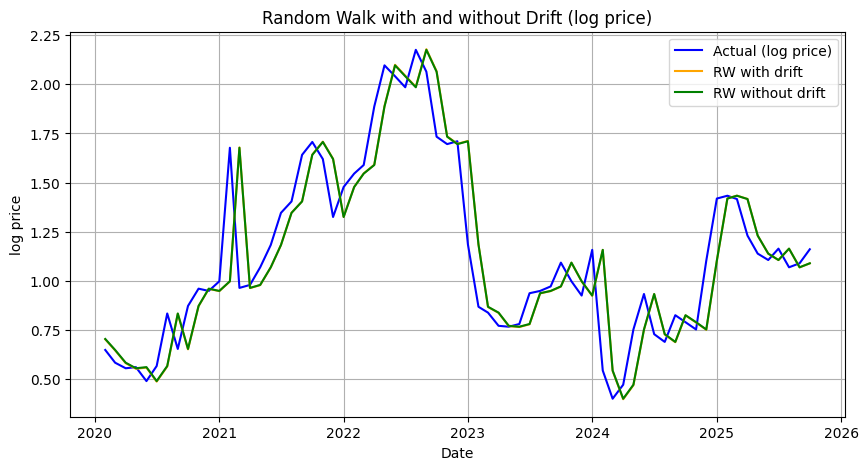

In [80]:
plt.figure(figsize=(10,5))

# Plot actual log price
plt.plot(a_rw_drift.index, a_rw_drift.values, label="Actual (log price)", color="blue")

# Plot RW with drift
plt.plot(f_rw_drift.index, f_rw_drift.values, label="RW with drift", color="orange")

# Plot RW no drift
plt.plot(f_rw_nodrift.index, f_rw_nodrift.values, label="RW without drift", color="green")

plt.title("Random Walk with and without Drift (log price)")
plt.xlabel("Date")
plt.ylabel("log price")
plt.legend()
plt.grid(True)
plt.show()

2. AR(1) on log price: ARIMA(1,0,0) 

In [18]:
f_ar1, a_ar1 = rolling_arima_forecast(
    y_full,
    order=tuple(best_order_uni),
    train_size=train_size
)

/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_41439/2314089204.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_41439/2314089204.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_41439/2314089204.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

In [19]:
# Compute error and RMSFE
rmsfe_ar1, mafe_ar1 = forecast_metrics(a_ar1, f_ar1)
print("AR(1) – RMSFE:", rmsfe_ar1, "MAFE:", mafe_ar1)

AR(1) – RMSFE: 0.20608011609787338 MAFE: 0.14104863378361163


Data prep for Alt model 2 - AR-X with oil price

In [20]:
# Load your dataset
oil = pd.read_csv("data/DCOILWTICO.csv")
oil['observation_date'] = pd.to_datetime(oil['observation_date'])
oil.set_index('observation_date', inplace=True)
oil.rename(columns={'DCOILWTICO': 'oil_price'}, inplace=True)

In [21]:
oil = oil.resample('MS').mean()

In [22]:
expected = pd.date_range(oil.index.min(), oil.index.max(), freq="MS")
missing = expected.difference(oil.index)
print(f"Missing months: {len(missing)}")

Missing months: 0


In [23]:
print(oil.head())
print(oil.tail())
print(f"Observations: {oil.notna().sum()}")

                  oil_price
observation_date           
1997-01-01        25.131818
1997-02-01        22.176316
1997-03-01        20.965000
1997-04-01        19.695455
1997-05-01        20.819048
                  oil_price
observation_date           
2025-06-01        68.169000
2025-07-01        68.390909
2025-08-01        64.864286
2025-09-01        63.959048
2025-10-01        62.590000
Observations: oil_price    346
dtype: int64


### Plot oil

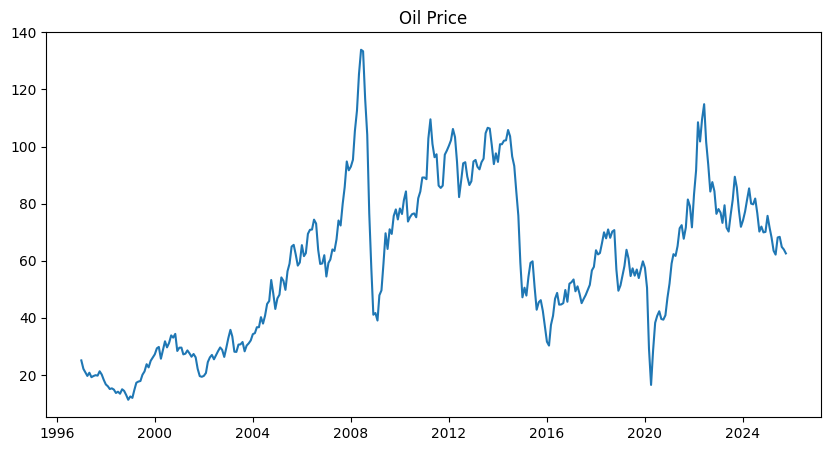

In [24]:
plt.figure(figsize=(10,5))
plt.plot(oil.index, oil['oil_price'], label='Price')
plt.title("Oil Price")
plt.show()

### Logarithmic transformation of oil price

In [25]:
oil['log_oil_price'] = np.log(oil['oil_price'])

In [26]:
print(oil.head())

                  oil_price  log_oil_price
observation_date                          
1997-01-01        25.131818       3.224135
1997-02-01        22.176316       3.099025
1997-03-01        20.965000       3.042854
1997-04-01        19.695455       2.980388
1997-05-01        20.819048       3.035868


### Plot log oil

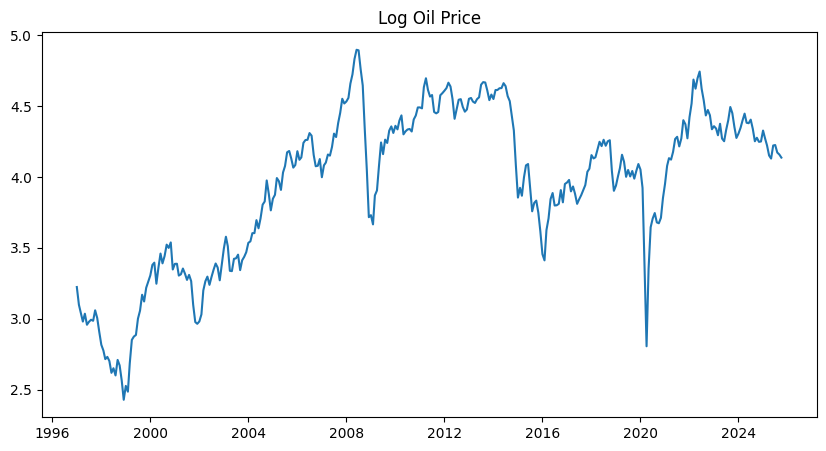

In [27]:
plt.figure(figsize=(10,5))
plt.plot(oil.index, oil['log_oil_price'], label='Price')
plt.title("Log Oil Price")
plt.show()

### Check stationarity with DF test on log_oil_price

In [28]:
def run_adf(x):
    res = adfuller(x.dropna(), autolag="AIC")
    return {"stat": res[0], "pvalue": res[1]}

log_x = oil['log_oil_price']

print("Log series:")
print("  ADF :", run_adf(log_x))

Log series:
  ADF : {'stat': np.float64(-2.283960217429215), 'pvalue': np.float64(0.17719331464393745)}


We fail to reject the null of a unit root so the series is non-stationary

### First difference

In [29]:
oil['dlog_oil'] = oil['log_oil_price'].diff()

### Check stationarity with DF test on dlog_oil

In [30]:
dlog_x = oil['dlog_oil']

print("Diff series:")
print("  ADF :", run_adf(dlog_x))

Diff series:
  ADF : {'stat': np.float64(-12.521038702549626), 'pvalue': np.float64(2.5481331700962578e-23)}


P-value is essentially zero so i strongly reject the unit root null

### Merge log gas and log oil on a new dataframe 

In [31]:

df = gas[['log_price']].join(oil['log_oil_price'], how='inner')

In [32]:
df['dlog'] = df['log_price'].diff()

In [33]:
df['dlog_oil'] = df['log_oil_price'].diff()

In [34]:
df.head()

,log_price,log_oil_price,dlog,dlog_oil
observation_date,,,,
1997-01-01,1.238374,3.224135,NaN,NaN
1997-02-01,0.765468,3.099025,-0.472906,-0.125110
1997-03-01,0.636577,3.042854,-0.128891,-0.056170
1997-04-01,0.708036,2.980388,0.071459,-0.062467
1997-05-01,0.810930,3.035868,0.102894,0.055480


In [35]:
df['dlog_oil_lag1'] = df['dlog_oil'].shift(1)

In [36]:
df = df.dropna()

Split training and test set

In [37]:
N2 = len(df)
test_size2 = int(np.ceil(0.2 * N2))

train2 = df.iloc[:N2 - test_size2]
test2  = df.iloc[N2 - test_size2:]

y2_full = df['dlog']                     # Δlog gas
X2_full = df[['dlog_oil', 'dlog_oil_lag1']]    # Δlog oil, contemporaneous + lag
train_size2 = len(train2)

### AIC/BIC model selection for AR-X on dlog with oil

In [38]:
y_train2 = train2['dlog']
X_train2 = train2[['dlog_oil', 'dlog_oil_lag1']]

candidate_orders_arx = [
    (0, 0, 0),
    (1, 0, 0),
    (2, 0, 0)
]

results_arx = []

for order in candidate_orders_arx:
    model = ARIMA(y_train2, order=order, exog=X_train2)
    fit   = model.fit()
    results_arx.append({
        "order": order,
        "aic": fit.aic,
        "bic": fit.bic
    })

aic_arx_df = pd.DataFrame(results_arx).sort_values("aic")
print(aic_arx_df)

best_order_arx = aic_arx_df.iloc[0]["order"]
print("Chosen AR-X ARIMA order (p,d,q):", best_order_arx)


       order         aic         bic
0  (0, 0, 0) -343.068820 -328.601735
1  (1, 0, 0) -341.099314 -323.015459
2  (2, 0, 0) -339.203465 -317.502838
Chosen AR-X ARIMA order (p,d,q): (0, 0, 0)


Helper: rolling ARIMA with exogenous regressors (AR-X)

In [39]:
def rolling_arima_exog(y, exog, order, train_size):
    """
    y: Series (dependent)
    exog: DataFrame/Series with exogenous regressors (same index as y)
    order: (p,d,q)
    """
    y = y.dropna()
    exog = exog.loc[y.index]  # align
    T = len(y)
    forecasts = []
    idx_fore = y.index[train_size:]

    for i in range(train_size, T):
        y_train   = y.iloc[:i]
        exog_train = exog.iloc[:i]
        exog_fore  = exog.iloc[i:i+1]

        model = ARIMA(y_train, order=order, exog=exog_train)
        fit   = model.fit()
        f     = fit.forecast(steps=1, exog=exog_fore)[0]
        forecasts.append(f)

    forecasts = pd.Series(forecasts, index=idx_fore)
    actuals   = y.iloc[train_size:]
    return forecasts, actuals

### 3. Alt model 2 - AR-X(1,1) on diff log gas with oil 

In [40]:
# Alt 2: AR-X – ARIMA(1,0,0) on dlog_price with exog oil diffs
f_arx, a_arx = rolling_arima_exog(
    y=y2_full,
    exog=X2_full,
    order=tuple(best_order_arx),
    train_size=train_size2
)

/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_41439/2003515562.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f     = fit.forecast(steps=1, exog=exog_fore)[0]
/Users/stefanialavarda/Time_Series_Project/ts-gas/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_41439/2003515562.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f     = fit.forecast(steps=1, exog=exog_fore)[0]
/var/fo

Compute error and RMSFE

In [41]:
rmsfe_arx, mafe_arx = forecast_metrics(a_arx, f_arx)
print("AR-X – RMSFE:", rmsfe_arx, "MAFE:", mafe_arx)

AR-X – RMSFE: 0.21071107509095585 MAFE: 0.14380083534449267


### Comparison plot

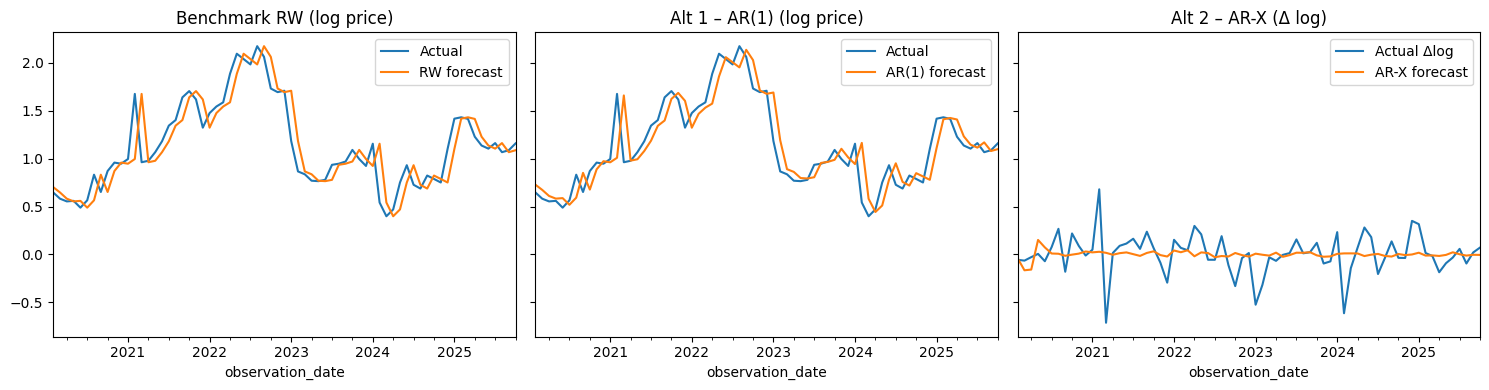

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(15,4), sharey=True)

a_rw.plot(ax=ax[0], label="Actual")
f_rw.plot(ax=ax[0], label="RW forecast")
ax[0].set_title("Benchmark RW (log price)")
ax[0].legend()

a_ar1.plot(ax=ax[1], label="Actual")
f_ar1.plot(ax=ax[1], label="AR(1) forecast")
ax[1].set_title("Alt 1 – AR(1) (log price)")
ax[1].legend()

a_arx.plot(ax=ax[2], label="Actual Δlog")
f_arx.plot(ax=ax[2], label="AR-X forecast")
ax[2].set_title("Alt 2 – AR-X (Δ log)")
ax[2].legend()

plt.tight_layout()
plt.show()

Build the VAR dataset & train/test split

In [81]:
from statsmodels.tsa.api import VAR

# Use only the two variables we need for VAR
var_df = df[['dlog', 'dlog_oil']].dropna()

# Train / test split (last 20% as test)
N_var = len(var_df)
test_size_var = int(np.ceil(0.2 * N_var))

train_var = var_df.iloc[:N_var - test_size_var]
test_var  = var_df.iloc[N_var - test_size_var:]

print("Train VAR:", train_var.index[0], "→", train_var.index[-1], f"(n={len(train_var)})")
print("Test VAR :", test_var.index[0],  "→", test_var.index[-1],  f"(n={len(test_var)})")

Train VAR: 1997-03-01 00:00:00 → 2020-01-01 00:00:00 (n=275)
Test VAR : 2020-02-01 00:00:00 → 2025-10-01 00:00:00 (n=69)


Model selection: choose VAR lag p using AIC/BIC

In [82]:
# VAR lag-order selection on training data
model_var = VAR(train_var)
lag_results = model_var.select_order(maxlags=6)  # try lags 1..6
print(lag_results.summary())

# choose p according to AIC (or BIC)
p_aic = lag_results.aic
p_bic = lag_results.bic
print("Lag selected by AIC:", p_aic)
print("Lag selected by BIC:", p_bic)

# pick one (say AIC)
p_var = p_aic

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -8.989     -8.962*   0.0001248      -8.978
1      -9.030      -8.950   0.0001198     -8.998*
2     -9.045*      -8.912  0.0001180*      -8.992
3      -9.029      -8.842   0.0001199      -8.954
4      -9.035      -8.795   0.0001191      -8.939
5      -9.010      -8.716   0.0001223      -8.891
6      -9.012      -8.664   0.0001220      -8.872
-------------------------------------------------
Lag selected by AIC: 2
Lag selected by BIC: 0


Recursive / expanding-window 1-step forecasts from VAR

In [83]:
def rolling_var_forecast(df, p, train_size):
    """
    df: DataFrame with columns ['dlog', 'dlog_oil']
    p: VAR lag order
    train_size: initial number of observations for the first estimation
    Returns: forecasts_df (DataFrame), actuals_df (DataFrame)
    """
    df = df.dropna()
    T = len(df)
    idx_fore = df.index[train_size:]
    forecasts = []

    for i in range(train_size, T):
        train_i = df.iloc[:i]
        model_i = VAR(train_i)
        res_i   = model_i.fit(p)
        # last p observations as initial state
        y_last = train_i.values[-p:]
        f_1 = res_i.forecast(y_last, steps=1)[0]  # 1-step ahead forecast
        forecasts.append(f_1)

    forecasts_df = pd.DataFrame(forecasts, index=idx_fore, columns=df.columns)
    actuals_df   = df.iloc[train_size:]
    return forecasts_df, actuals_df

# Use full var_df and train_size = len(train_var)
train_size_var = len(train_var)

var_forecasts, var_actuals = rolling_var_forecast(
    var_df,
    p=p_var,
    train_size=train_size_var
)


Evaluation: RMSFE & MAFE for gas equation

In [84]:
f_var_gas = var_forecasts['dlog']
a_var_gas = var_actuals['dlog']

rmsfe_var, mafe_var = forecast_metrics(a_var_gas, f_var_gas)
print("VAR – RMSFE:", rmsfe_var, "MAFE:", mafe_var)

VAR – RMSFE: 0.20884963117527816 MAFE: 0.1439890648344518


Plot: VAR forecasts vs actual (Δ log gas)

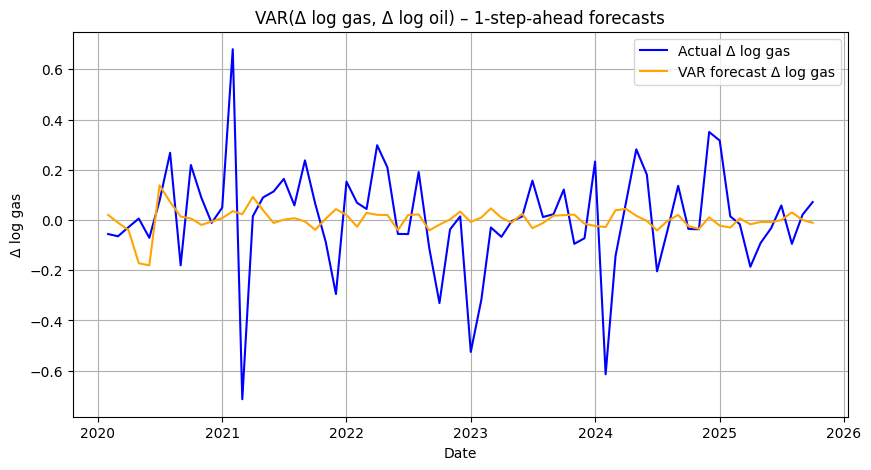

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(a_var_gas.index, a_var_gas.values, label="Actual Δ log gas", color="blue")
plt.plot(f_var_gas.index, f_var_gas.values, label="VAR forecast Δ log gas", color="orange")
plt.title("VAR(Δ log gas, Δ log oil) – 1-step-ahead forecasts")
plt.xlabel("Date")
plt.ylabel("Δ log gas")
plt.legend()
plt.grid(True)
plt.show()